In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from math import sqrt
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
import math

import wrangle

Load your zillow dataset.

In [12]:
df = wrangle.wrangle_zillow()

In [13]:
train, validate, test = wrangle.train_validate_test_split(df)
train.shape, validate.shape, test.shape

((1169459, 7), (501197, 7), (417665, 7))

In [15]:
train.columns

Index(['bedroomcnt', 'bathroomcnt', 'square_feet', 'taxvaluedollarcnt',
       'yearbuilt', 'taxamount', 'fips_name'],
      dtype='object')

Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calfulatedfinishedsqft.

In [16]:
# drop all columns other than main 2
train.drop(columns = ['bedroomcnt', 'bathroomcnt', 'yearbuilt', 'taxamount', 'fips_name'], inplace=True)

In [21]:
x_train = train[['square_feet']]
y_train = train['taxvaluedollarcnt']

x_validate = validate[['square_feet']]
y_validate = validate['taxvaluedollarcnt']

x_test = test[['square_feet']]
y_test = test['taxvaluedollarcnt']

In [22]:
x_train

,square_feet
1483210,1733
635933,1766
647772,2665
1251279,612
772816,1148
...,...
602633,1082
1749433,912
1921252,1792
1322629,1141


In [23]:
# Create baseline
baseline = train.taxvaluedollarcnt.mean()
baseline

399170.80015887687

In [24]:
train['baseline'] = train.taxvaluedollarcnt.mean()
train.head()

,square_feet,taxvaluedollarcnt,baseline
1483210,1733,98022,399170.800159
635933,1766,117631,399170.800159
647772,2665,762659,399170.800159
1251279,612,21957,399170.800159
772816,1148,202092,399170.800159


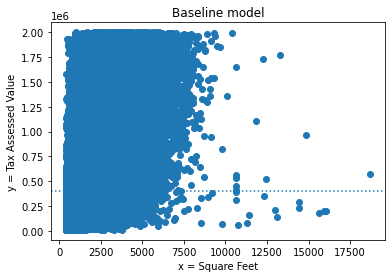

In [25]:
plt.scatter(train.square_feet, train.taxvaluedollarcnt)
plt.axhline(train.taxvaluedollarcnt.mean(), ls = ':')
plt.xlabel('x = Square Feet')
plt.ylabel('y = Tax Assessed Value')
plt.title('Baseline model');

In [28]:
model = LinearRegression().fit(x_train, y_train)
predictions = model.predict(x_train)
train['yhat'] = predictions
train.head(5)

,square_feet,taxvaluedollarcnt,baseline,yhat
1483210,1733,98022,399170.800159,383838.586259
635933,1766,117631,399170.800159,391585.248798
647772,2665,762659,399170.800159,602623.116149
1251279,612,21957,399170.800159,120686.807283
772816,1148,202092,399170.800159,246511.386704


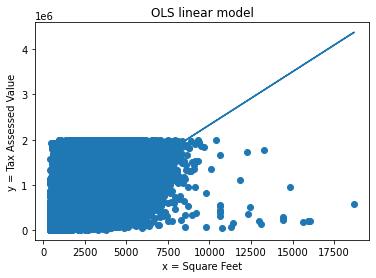

In [29]:
plt.scatter(train.square_feet, train.taxvaluedollarcnt)
plt.plot(train.square_feet, train.yhat)
plt.xlabel('x = Square Feet')
plt.ylabel('y = Tax Assessed Value')
plt.title('OLS linear model');

Plot the residuals for the linear regression model that you made.

In [31]:
# residual = actual - predicted
train['residual'] = train.taxvaluedollarcnt - train.yhat
train['baseline_residual'] = train.taxvaluedollarcnt - train.baseline
train.head(5)

,square_feet,taxvaluedollarcnt,baseline,yhat,residual,baseline_residual
1483210,1733,98022,399170.800159,383838.586259,-285816.586259,-301148.800159
635933,1766,117631,399170.800159,391585.248798,-273954.248798,-281539.800159
647772,2665,762659,399170.800159,602623.116149,160035.883851,363488.199841
1251279,612,21957,399170.800159,120686.807283,-98729.807283,-377213.800159
772816,1148,202092,399170.800159,246511.386704,-44419.386704,-197078.800159


Negative Residual = Prediction too high

Positive Residual = Prediction too low

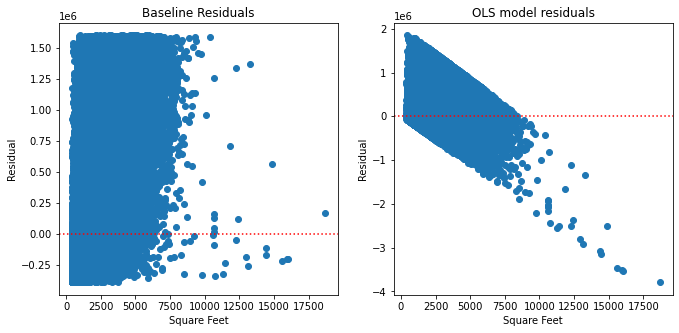

In [34]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train.square_feet, train.baseline_residual)
plt.axhline(y = 0, ls = ':', color='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(train.square_feet, train.residual)
plt.axhline(y = 0, ls = ':', color ='red')
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('OLS model residuals');

In [35]:
baseline_residual_min = train.baseline_residual.min()
baseline_residual_max = train.baseline_residual.max()
residual_min = train.residual.min()
residual_max = train.residual.max()
residual_min, residual_max

(-3797416.846856541, 1849320.8110693041)

Negative Residual = Prediction too high
Positive Residual = Prediction too low


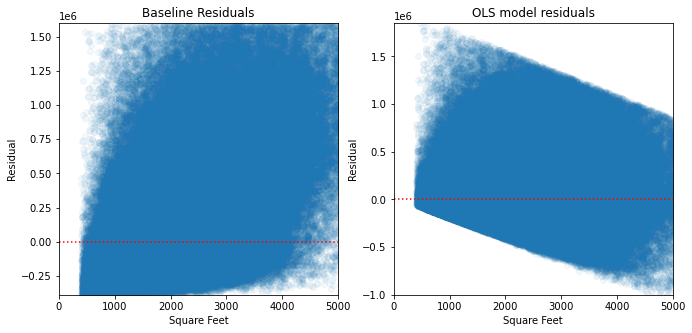

In [36]:
# residual plots (x vs residual)

plt.figure(figsize = (11,5))

plt.subplot(121)
plt.scatter(train.square_feet, train.baseline_residual, alpha=.05)
plt.axhline(y = 0, ls = ':', color = 'red')
plt.xlim(0,5000)
plt.ylim(baseline_residual_min, baseline_residual_max)
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('Baseline Residuals')

plt.subplot(122)
plt.scatter(train.square_feet, train.residual, alpha=0.05)
plt.axhline(y = 0, ls = ':', color ='red')
plt.xlim(0,5000)
plt.ylim(-1_000_000, residual_max)
plt.xlabel('Square Feet')
plt.ylabel('Residual')
plt.title('OLS model residuals')
print("Negative Residual = Prediction too high")
print("Positive Residual = Prediction too low")

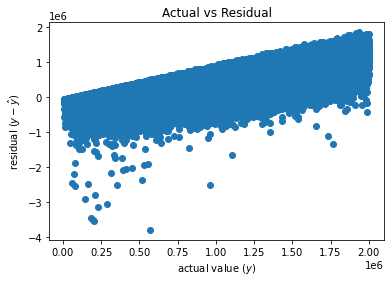

In [37]:
# Residual plot (y vs residual)
actual = train.taxvaluedollarcnt
predicted = train.yhat
residuals = actual - predicted
plt.hlines(0, actual.min(), actual.max(), ls=':')
plt.scatter(actual, residuals)
plt.ylabel('residual ($y - \hat{y}$)')
plt.xlabel('actual value ($y$)')
plt.title('Actual vs Residual')
plt.show()

Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.


Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).

In [38]:
train['residual^2'] = train.residual**2
train['baseline_residual^2'] = train.baseline_residual**2

train.head()

,square_feet,taxvaluedollarcnt,baseline,yhat,residual,baseline_residual,residual^2,baseline_residual^2
1483210,1733,98022,399170.800159,383838.586259,-285816.586259,-301148.800159,8.169112e+10,9.069060e+10
635933,1766,117631,399170.800159,391585.248798,-273954.248798,-281539.800159,7.505093e+10,7.926466e+10
647772,2665,762659,399170.800159,602623.116149,160035.883851,363488.199841,2.561148e+10,1.321237e+11
1251279,612,21957,399170.800159,120686.807283,-98729.807283,-377213.800159,9.747575e+09,1.422903e+11
772816,1148,202092,399170.800159,246511.386704,-44419.386704,-197078.800159,1.973082e+09,3.884005e+10


##### Calculate SSE (Sum of Squared Errors)

In [39]:
SSE = train['residual^2'].sum()
SSE_baseline = train['baseline_residual^2'].sum()

print('SSE =', "{:.1f}".format(SSE))
print("SSE Baseline =", "{:.1f}".format(SSE_baseline))

SSE = 75444979259156576.0
SSE Baseline = 115093177467709056.0


In [40]:
SSE < SSE_baseline

True

##### Calculate MSE (Mean Squared Error)

In [41]:
MSE = SSE/len(train)
MSE_baseline = SSE_baseline/len(train)

print("MSE = ", "{:.1f}".format(MSE))
print("MSE baseline = ", "{:.1f}".format(MSE_baseline))

MSE =  64512718495.6
MSE baseline =  98415743918.9


##### Calculate RMSE (Root Mean Squared Error)

In [42]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline =  sqrt(MSE_baseline)


print("RMSE = ", "{:.1f}".format(RMSE))
print("RMSE baseline = ", "{:.1f}".format(RMSE_baseline))

RMSE =  253993.5
RMSE baseline =  313712.8


Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.

In [43]:
if SSE < SSE_baseline:
    print('OLS Regression Model Performs Better than Baseline')
else:
    print('OLS Regression Model Performs Worse than Baseline')

OLS Regression Model Performs Better than Baseline


What is the amount of variance explained in your model?


In [44]:
# calculate R2 manually:

# Total Sum of Squares = SSE for baseline
TSS = SSE_baseline = train['baseline_residual^2'].sum()

# Sum of squared error for the regression line (Unexplained error)
SSE = train['residual^2'].sum()

# ESS - Explained sum of squares ('Explained Error')
ESS = TSS - SSE

# Calculate R2
R2 = ESS/TSS
R2

0.3444878235260845

In [45]:
# calculate R2 the easy way:

from sklearn.metrics import r2_score
r2_score(train.taxvaluedollarcnt, train.yhat)

0.34448782352608454

Is your model better than the baseline model?

In [46]:
X2 = sm.add_constant(train.square_feet)
est = sm.OLS(train.taxvaluedollarcnt, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:      taxvaluedollarcnt   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                 6.146e+05
Date:                Fri, 03 Jun 2022   Prob (F-statistic):               0.00
Time:                        15:44:23   Log-Likelihood:            -1.6213e+07
No. Observations:             1169459   AIC:                         3.243e+07
Df Residuals:                 1169457   BIC:                         3.243e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -2.298e+04    587.483    -39.114      

Create a file named evaluate.py that contains the following functions.

-plot_residuals(y, yhat): creates a residual plot

-regression_errors(y, yhat): returns the following values:
-sum of squared errors (SSE)
-explained sum of squares (ESS)
-total sum of squares (TSS)
-mean squared error (MSE)
-root mean squared error (RMSE)

-baseline_mean_errors(y): computes the SSE, MSE, and RMSE for the baseline model

-better_than_baseline(y, yhat): returns true if your model performs better than the baseline, otherwise false